In [1]:
from typing import Dict, Iterator, List, Tuple, Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import warnings
warnings.filterwarnings("ignore")

In [2]:
class Settings:
    
    def __init__(self,
                 number_of_ticks: int,
                 number_of_customers: int,
                 number_of_counters: int,
                 revenue_per_customer: int, 
                 cost_per_counter: int,  
                 balking_tolerance: Tuple[int, int], 
                 avg_service_time: int, 
                 avg_absence_time: int, 
                 leave_prob: float, 
                 is_changing_included: bool = False, 
                 is_leaving_included: bool = False):
        
        self.number_of_ticks = number_of_ticks
        self.number_of_customers = number_of_customers
        self.number_of_counters = number_of_counters
        self.revenue_per_customer = revenue_per_customer
        self.cost_per_counter = cost_per_counter
        self.balking_tolerance = balking_tolerance
        self.avg_service_time = avg_service_time
        self.avg_absence_time = avg_absence_time
        self.leave_prob = leave_prob
        self.is_changing_included = is_changing_included
        self.is_leaving_included = is_leaving_included
    
    def __iter__(self):
        yield "number_of_ticks", self.number_of_ticks
        yield "number_of_customers", self.number_of_customers
        yield "number_of_counters", self.number_of_counters
        yield "revenue_per_customer", self.revenue_per_customer
        yield "cost_per_counter", self.cost_per_counter
        yield "balking_tolerance", self.balking_tolerance
        yield "avg_service_time", self.avg_service_time
        yield "avg_absence_time", self.avg_absence_time
        yield "leave_probability", self.leave_prob
        yield "is_changing_included", self.is_changing_included
        yield "is_leaving_included", self.is_leaving_included

In [15]:
class Customer:
    
    def __init__(self, settings: Settings, unique_id: int, model):
        self.model = model
        self.unique_id = unique_id
        
        # Время прихода клиента в супермаркет:
        self.entry_time = int(np.random.beta(a=3, b=3) * settings["number_of_ticks"])
        
        # Время, необходимое для обслуживания одного клиента на кассе:
        self.service_time = np.random.poisson(lam=settings["avg_service_time"])
        
        # Время отсутствия клиента в случае, если клиент решит уйти из супермаркета:
        self.avg_absence_time = np.random.poisson(lam=settings["avg_absence_time"])
        
        # Максимальная длина очереди за кассой, при которой клиент готов к ней присоединиться:
        self.balk_tolerance = np.random.randint(low=settings["balking_tolerance"][0], high=settings["balking_tolerance"][1])
        
        # Вероятность покинуть супермаркет по срочным делам:
        self.leave_probability = settings["leave_probability"]
        
        # Индикатор включения в поведение покупателя метода "try_changing_queue":
        self.is_changing_included = settings["is_changing_included"]
        
        # Индикатор включения в поведение покупателя метода "leave_n_return":
        self.is_leaving_included = settings["is_leaving_included"]
        
        # Индикатор появления клиента в супермаркете:
        self._arrived = False
        # Индикатор того, покидал ли клиент уже супермаркет по срочным делам:
        self.did_leave = False
        # Касса, выбранная клиентом:
        self._chosen_counter = None
        # Время, когда клиент присоединился к очереди:
        self._q_entry = None
        # Время, когда клиента начинают обслуживать на кассе:
        self._service_entry = None
        # Время, когда клиента закончили обслуживать на кассе:
        self._service_exit = None
        
    def select_counter(self):
        self._arrived = True
        
        # Клиент выбирает кассу с самой короткой очередью:
        self._chosen_counter_idx = np.argmin([
            len(counter.queue) for counter in self.model.counters])
        self._chosen_counter = self.model.counters[
            self._chosen_counter_idx]
        
        # Клиент присоединяется к выбранной кассе, если очередь за ней не превышает его "длину терпимости":
        if len(self._chosen_counter.queue) < self.balk_tolerance:
            self._chosen_counter.queue.append(self)
            self._chosen_counter.queue_order.append(self.unique_id)
            self._q_entry = self.model._current_tick
    
    def try_changing_queue(self):
        current_position = self._chosen_counter.queue_order.index(self.unique_id)
        the_shortest_queue_idx = np.argmin([len(counter.queue) for counter in self.model.counters
                                            if counter.unique_id != self._chosen_counter_idx])
        
        # Если клиент нашел очередь с длиной меньше хотя бы на 2 позиции, чем его нынешняя очередь, он меняет свою очередь:
        if (current_position + 1) - len(self.model.counters[the_shortest_queue_idx].queue) >= 2:
            self._chosen_counter.queue.pop(current_position)
            self._chosen_counter.queue_order.pop(current_position)
                
            self._chosen_counter_idx = the_shortest_queue_idx
            self._chosen_counter = self.model.counters[self._chosen_counter_idx]
                
            self._chosen_counter.queue.append(self)
            self._chosen_counter.queue_order.append(self.unique_id)
                
            self.model.jockeying_number += 1        
            
    def leave_n_return(self, leave_probability: float):
        is_leaving = np.random.binomial(1, leave_probability)
        
        if is_leaving == 1:
            current_position = self._chosen_counter.queue_order.index(self.unique_id)
            
            self._chosen_counter.queue.pop(current_position)
            self._chosen_counter.queue_order.pop(current_position)
            
            self._arrived = False
            self._chosen_counter = None
            self._q_entry = None
            
            self.entry_time = self.model._current_tick + self.avg_absence_time
            
            self.did_leave = True
            self.model.n_leavings += 1
    
    def pay_n_leave(self):
        self._service_exit = self.model._current_tick
        self._chosen_counter.active_customer = None
        
    def step(self):
        if self._arrived == False and self.model._current_tick >= self.entry_time:
            self.select_counter()
            
        elif self._q_entry != None and self._service_entry == None:
            if self.is_leaving_included and self.did_leave == False:
                self.leave_n_return(self.leave_probability)
            if self.is_changing_included and self._arrived == True:
                self.try_changing_queue()
                    
        elif self._service_entry != None:
            if self.model._current_tick - self._service_entry == self.service_time:
                self.pay_n_leave()

In [16]:
class Counter:
    
    def __init__(self, unique_id: int, model):
        self.model = model
        self.unique_id = unique_id
        self.queue = []
        self.queue_order = []
        self.active_customer = None
        
    def dequeue(self):
        if len(self.queue) >= 1:
            self.queue_order = self.queue_order[1:]
            self.active_customer = self.queue.pop(0)
            self.active_customer._service_entry = self.model._current_tick
        
    def step(self):
        if self.active_customer is None:
            self.dequeue()

In [17]:
class RandomActivation:

    def __init__(self) -> None:

        self._agents: Dict[int, Union[Customer, Counter]] = dict()

    def add(self, agent) -> None:
        self._agents[agent.unique_id] = agent

    def step(self) -> None:

        for agent in self.agent_buffer(shuffled=True):
            agent.step()

    def agent_buffer(self, shuffled: bool = False) -> Iterator[Union[Customer, Counter]]:

        agent_keys = list(self._agents.keys())
        if shuffled:
            random.shuffle(agent_keys)

        for key in agent_keys:
            if key in self._agents:
                yield self._agents[key]

In [18]:
class QueueModel:

    def __init__(self, settings: Settings):
        self._current_tick = 1
        self.jockeying_number = 0
        self.n_leavings = 0
        self.schedule = RandomActivation()
        self.ticks = settings["number_of_ticks"]
        self.no_customers = settings["number_of_customers"]
        self.no_counters = settings["number_of_counters"]
        self.revenue_per_customer = settings["revenue_per_customer"]
        self.cost_per_counter = settings["cost_per_counter"]
        
        # Хранилища для сбора данных:
        self.no_customers_arrived = []
        self.no_customers_served = []
        self.no_customers_balked = []
        self.avg_queue_size = []
        self.avg_customer_wait = []
        self.revenue = []
        self.operating_costs = []
        self.total_profit = []
        self.jockeying = []
        self.leavings = []
        
        # Инциализация агентов:
        self.customers = []
        self.counters = []
        
        for i in range(self.no_customers):
            customer = Customer(settings, i, self)
            self.schedule.add(customer)
            self.customers.append(customer)
            
        for i in range(self.no_counters):
            counter = Counter(i + self.no_customers, self)
            self.schedule.add(counter)
            self.counters.append(counter)
            
    def collect_data(self):
        
        customers_arrived = [customer._arrived for customer in self.customers]
        no_customers_arrived = np.sum(customers_arrived)
        self.no_customers_arrived.append(no_customers_arrived)
        
        customers_served = [not(customer._service_exit is None) for customer in self.customers]
        no_customers_served = np.sum(customers_served)
        self.no_customers_served.append(no_customers_served)
        
        customers_arrived = [customer._arrived for customer in self.customers]
        customers_no_q = np.array([customer._q_entry is None for customer in self.customers])
        no_customers_balked = np.sum(customers_arrived * customers_no_q)
        self.no_customers_balked.append(no_customers_balked)
        
        queue_size = [len(counter.queue) for counter in self.counters]
        avg_queue_size = np.mean(queue_size)
        self.avg_queue_size.append(avg_queue_size)
        
        customers_wait = [np.nan if customer._service_entry is None else
                          customer._service_entry - customer._q_entry for customer in self.customers]
        avg_customer_wait = np.nanmean(customers_wait)
        self.avg_customer_wait.append(avg_customer_wait)
        
        self.revenue.append(self.revenue_per_customer * no_customers_served)
        
        self.operating_costs.append(self.cost_per_counter * self.no_counters)
        
        self.total_profit.append(self.revenue_per_customer * no_customers_served - self.cost_per_counter * self.no_counters)
        
        self.jockeying.append(self.jockeying_number)
        self.leavings.append(self.n_leavings)
        
    def step(self):
        self.schedule.step()
        self.collect_data()
        self.jockeying_number = 0
        self.n_leavings = 0
        self._current_tick += 1

In [61]:
customers_arrived = []
customers_served = []
customers_balked = []
avg_waiting_time = []
avg_queue_size = []
gross_margin = []
operating_costs = []
total_profit = []

n_counters_range = np.arange(3, 15)

for n_counters in n_counters_range:
    
    settings = dict(
        Settings(
            number_of_ticks=3600,
            number_of_customers=500,
            number_of_counters=n_counters,
            revenue_per_customer=10,
            cost_per_counter=300,
            balking_tolerance=(3, 10),
            avg_service_time=45,
            avg_absence_time=600,
            leave_prob=0.05,
            is_changing_included=True,
            is_leaving_included=True
        )
    )
    
    model = QueueModel(settings)
    for i in range(settings["number_of_ticks"]):
        model.step()
        
    customers_arrived.append(model.no_customers_arrived[-1])
    customers_served.append(model.no_customers_served[-1])
    customers_balked.append(model.no_customers_balked[-1])
    avg_waiting_time.append(model.avg_customer_wait[-1])
    avg_queue_size.append(model.avg_queue_size[-1])
    gross_margin.append(model.revenue[-1])
    operating_costs.append(model.operating_costs[-1])
    total_profit.append(model.total_profit[-1])
    
data = pd.DataFrame({"Customers arrived": customers_arrived, "Customers served": customers_served,
                     "Customers balked": customers_balked, "Average waiting time": avg_waiting_time,
                     "Gross margin": gross_margin, "Operating costs": operating_costs,
                     "Total profit": total_profit}, index=n_counters_range)

In [63]:
data

,Customers arrived,Customers served,Customers balked,Average waiting time,Gross margin,Operating costs,Total profit
3,491,201,278,186.549020,2010,900,1110
4,492,258,220,148.687023,2580,1200,1380
5,494,305,173,151.567742,3050,1500,1550
6,486,364,107,103.881081,3640,1800,1840
7,487,402,83,96.136139,4020,2100,1920
8,487,445,39,74.997763,4450,2400,2050
9,485,471,3,43.442348,4710,2700,2010
10,488,478,0,25.669421,4780,3000,1780
11,490,488,0,22.055215,4880,3300,1580
12,494,492,0,23.253036,4920,3600,1320


In [40]:
settings = dict(
    Settings(
        number_of_ticks=3600,
        number_of_customers=500,
        number_of_counters=5,
        revenue_per_customer=10,
        cost_per_counter=300,
        balking_tolerance=(3, 10),
        avg_service_time=45,
        avg_absence_time=600,
        leave_prob=0.05,
        is_changing_included=False,
        is_leaving_included=False
    )
)
model_1 = QueueModel(settings)
for i in range(settings["number_of_ticks"]):
    model_1.step()

In [41]:
settings = dict(
    Settings(
        number_of_ticks=3600,
        number_of_customers=500,
        number_of_counters=5,
        revenue_per_customer=10,
        cost_per_counter=300,
        balking_tolerance=(3, 10),
        avg_service_time=45,
        avg_absence_time=600,
        leave_prob=0.05,
        is_changing_included=True,
        is_leaving_included=True
    )
)
model_2 = QueueModel(settings)
for i in range(settings["number_of_ticks"]):
    model_2.step()

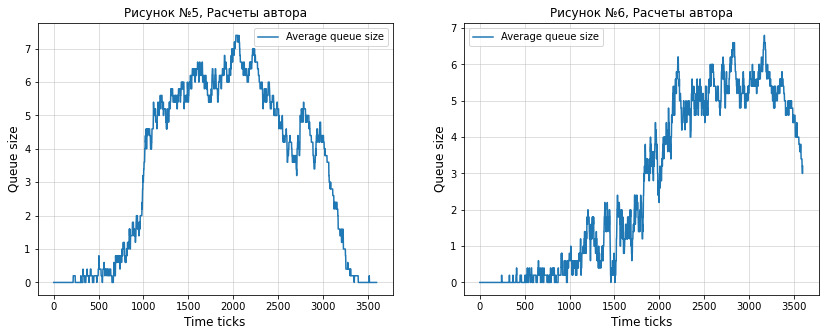

In [42]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(np.arange(3600), model_1.avg_queue_size, label="Average queue size")
plt.title("Рисунок №5, Расчеты автора")
plt.xlabel("Time ticks", fontsize=12)
plt.ylabel("Queue size", fontsize=12)
plt.grid(alpha=0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(3600), model_2.avg_queue_size, label="Average queue size")
plt.title("Рисунок №6, Расчеты автора")
plt.xlabel("Time ticks", fontsize=12)
plt.ylabel("Queue size", fontsize=12)
plt.grid(alpha=0.5)
plt.legend()

plt.show()

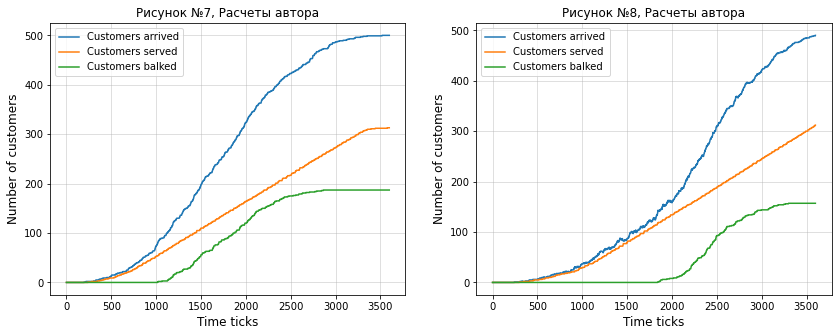

In [51]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(np.arange(3600), model_1.no_customers_arrived, label="Customers arrived")
plt.plot(np.arange(3600), model_1.no_customers_served, label="Customers served")
plt.plot(np.arange(3600), model_1.no_customers_balked, label="Customers balked")
plt.title("Рисунок №7, Расчеты автора")
plt.xlabel("Time ticks", fontsize=12)
plt.ylabel("Number of customers", fontsize=12)
plt.grid(alpha=0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(3600), model_2.no_customers_arrived, label="Customers arrived")
plt.plot(np.arange(3600), model_2.no_customers_served, label="Customers served")
plt.plot(np.arange(3600), model_2.no_customers_balked, label="Customers balked")
plt.title("Рисунок №8, Расчеты автора")
plt.xlabel("Time ticks", fontsize=12)
plt.ylabel("Number of customers", fontsize=12)
plt.grid(alpha=0.5)
plt.legend()

plt.savefig("figure.png")

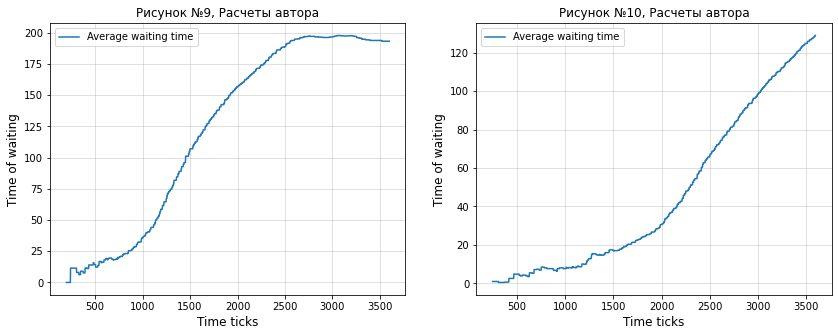

In [52]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(np.arange(3600), model_1.avg_customer_wait, label="Average waiting time")
plt.xlabel("Time ticks", fontsize=12)
plt.ylabel("Time of waiting", fontsize=12)
plt.title("Рисунок №9, Расчеты автора")
plt.grid(alpha=0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(3600), model_2.avg_customer_wait, label="Average waiting time")
plt.xlabel("Time ticks", fontsize=12)
plt.ylabel("Time of waiting", fontsize=12)
plt.title("Рисунок №10, Расчеты автора")
plt.grid(alpha=0.5)
plt.legend()

plt.savefig("figure.png")

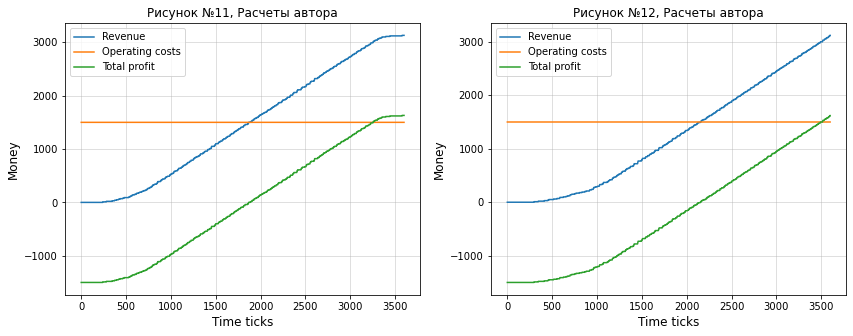

In [53]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(np.arange(3600), model_1.revenue, label="Revenue")
plt.plot(np.arange(3600), model_1.operating_costs, label="Operating costs")
plt.plot(np.arange(3600), model_1.total_profit, label="Total profit")
plt.xlabel("Time ticks", fontsize=12)
plt.ylabel("Money", fontsize=12)
plt.title("Рисунок №11, Расчеты автора")
plt.grid(alpha=0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(3600), model_2.revenue, label="Revenue")
plt.plot(np.arange(3600), model_2.operating_costs, label="Operating costs")
plt.plot(np.arange(3600), model_2.total_profit, label="Total profit")
plt.xlabel("Time ticks", fontsize=12)
plt.ylabel("Money", fontsize=12)
plt.title("Рисунок №12, Расчеты автора")
plt.grid(alpha=0.5)
plt.legend()

plt.savefig("figure.png")

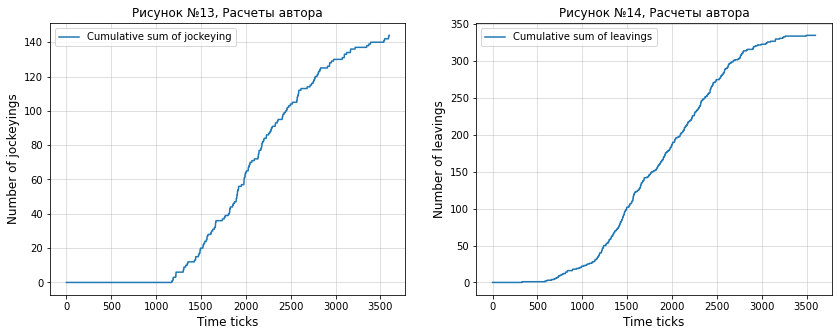

In [60]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(np.arange(3600), np.cumsum(model.jockeying), label="Cumulative sum of jockeying")
plt.xlabel("Time ticks", fontsize=12)
plt.ylabel("Number of jockeyings", fontsize=12)
plt.title("Рисунок №13, Расчеты автора")
plt.grid(alpha=0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(3600), np.cumsum(model.leavings), label="Cumulative sum of leavings")
plt.xlabel("Time ticks", fontsize=12)
plt.ylabel("Number of leavings", fontsize=12)
plt.title("Рисунок №14, Расчеты автора")
plt.grid(alpha=0.5)
plt.legend()

plt.savefig("figure.png")